In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sqlite3 import connect

df = pd.read_csv('vgchartz-2024.csv')

In [48]:
class VideoGameSalesAnalyzer:
    def __init__(self, data_file):
        self.df = pd.read_csv(data_file)
    
    def clean_data(self):
        self.df = self.df.copy()
        self.df['release_date'] = pd.to_datetime(self.df['release_date'])
        self.df.drop(['img', 'last_update'], axis=1, inplace=True)
        self.df = self.df.dropna(subset=['release_date'])
        columns_to_fill_zero = ['critic_score', 'total_sales', 'na_sales', 'jp_sales', 'pal_sales', 'other_sales']
        self.df.loc[:, columns_to_fill_zero] = self.df.loc[:, columns_to_fill_zero].fillna(0)
    
    def assign_console_mfg(self):
        categories = {
            'nintendo': ['3DS', 'ds', 'Wii', 'WiiU', 'NS', 'GB', 'NES', 'SNES', 'GBC', 'N64'],
            'pc': ['Linux', 'OSX', 'PC', 'Arc', 'All'],
            'xbox': ['X360', 'XOne', 'Series'],
            'sony': ['PS', 'PS2', 'PS3', 'PS4', 'PS5', 'PSP', 'PSV', 'PSN'],
            'mobile': ['iOS', 'And'],
            'sega': ['GG', 'MSD', 'MS', 'GEN', 'SCD'],
            'atari': ['2600', '7800'],
            'commodore': ['amig', 'C64'],
            'other': ['Ouya', 'OR', 'ACPC', 'AST', 'ApII', 'PCE', 'ZXS', 'Lynx', 'NG', 'ZXS']
        }

        all_items = [item for sublist in categories.values() for item in sublist]

        missing_items = self.check_missing_items(all_items)

        if missing_items:
            print(f"Missing items: {missing_items}")
        else:
            print("All items are covered.")

        conditions = [self.df['console'].isin(items) for items in categories.values()]
        values = list(categories.keys())

        self.df['console_mfg'] = np.select(conditions, values, default='unknown')
    
    def check_missing_items(self, all_items):
        all_items_lower = [item.lower().strip() for item in all_items]
        unique_values_lower = set(self.df['console'].str.lower().str.strip().unique())
        return set(all_items_lower) - unique_values_lower

    def filter_and_group_by_year(self, target_year):
        self.df['release_date'] = pd.to_datetime(self.df['release_date'])
        df_filtered = self.df[self.df['release_date'].dt.year == target_year]
        result = df_filtered.groupby(['release_date', 'console'])['total_sales'].sum().reset_index()
        result['release_date'] = result['release_date'].dt.year  
        result = result.groupby(['release_date', 'console'])['total_sales'].sum().reset_index()
        return result

    def single_graph(self, date_range, console):
        self.df['release_date'] = pd.to_datetime(self.df['release_date'])
        filtered_df = self.df[(self.df['release_date'].dt.year >= date_range[0]) & 
                              (self.df['release_date'].dt.year <= date_range[1]) & 
                              (self.df['console'] == console)]

        sales_by_year = filtered_df.groupby(filtered_df['release_date'].dt.year)['total_sales'].sum().reset_index()

        plt.figure(figsize=(10, 6))
        plt.bar(sales_by_year['release_date'], sales_by_year['total_sales'], label='Total Sales')
        
        # Trend curve
        x = sales_by_year['release_date']
        y = sales_by_year['total_sales']
        z = np.polyfit(x, y, 2)
        p = np.poly1d(z)
        trend_line = np.maximum(p(x), 0)  
        plt.plot(x, trend_line, 'r--', label='Trend Curve')
        
        plt.xlabel('Year')
        plt.ylabel('Total Sales')
        plt.title(f'Total Sales of {console} from {date_range[0]} to {date_range[1]}')
        plt.legend()
        
        plt.show()

    def stacked_graph(self, date_range, *consoles):
        self.df['release_date'] = pd.to_datetime(self.df['release_date'])
        filtered_df = self.df[(self.df['release_date'].dt.year >= date_range[0]) & 
                              (self.df['release_date'].dt.year <= date_range[1]) & 
                              (self.df['console'].isin(consoles))]
        sales_by_year = filtered_df.groupby(['release_date', 'console'])['total_sales'].sum().reset_index()

        plt.figure(figsize=(12, 8))

        for console in consoles:
            console_data = sales_by_year[sales_by_year['console'] == console]
            x = console_data['release_date'].dt.year  
            y = console_data['total_sales']
        
            # Trend curve
            z = np.polyfit(x, y, 2)
            p = np.poly1d(z)
            # Clip values below 0
            trend_line = np.maximum(p(x), 0) 
        
            # Bar plot
            plt.bar(x, y, label=f'Total Sales - {console}')
        
            # Trend curve plot
            plt.plot(x, trend_line, '--', label=f'Trend Curve - {console}')

        plt.xlabel('Year')
        plt.ylabel('Total Sales')
        plt.title(f'Total Sales Comparison of Consoles from {date_range[0]} to {date_range[1]}')

        # Display legend
        plt.legend()

        plt.show()
    
    def graph_genre_quarterly(self, date_range, *genres):
      
        self.df['release_date'] = pd.to_datetime(self.df['release_date'])
        
        filtered_df = self.df[(self.df['release_date'].dt.year >= date_range[0]) & 
                        (self.df['release_date'].dt.year <= date_range[1]) & 
                        (self.df['genre'].isin(genres))].copy()
        
        filtered_df['quarter'] = filtered_df['release_date'].dt.to_period("Q")
        
        sales_by_quarter = filtered_df.groupby(['quarter', 'genre'])['total_sales'].sum().reset_index()

        plt.figure(figsize=(15, 8))
        
        quarters = sales_by_quarter['quarter'].unique().astype(str)
        width = 0.2  # Adjusted width to make bars side-by-side
        
        for i, genre in enumerate(genres):
            genre_data = sales_by_quarter[sales_by_quarter['genre'] == genre]
            x = np.arange(len(quarters)) + i * width  # Adjusted x positions for side-by-side bars
            y = genre_data.groupby('quarter')['total_sales'].sum().reindex(quarters).fillna(0)
            
            cmap = plt.get_cmap('tab10')
            bar_color = cmap(i)
            
            plt.bar(x, y, width=width, color=bar_color, label=genre)
        
        plt.xlabel('Quarter')
        plt.ylabel('Total Sales')
        plt.title(f'Total Sales Comparison of Genres from {date_range[0]} to {date_range[1]} (Quarterly)')
        
        plt.legend(loc='upper left')
        plt.xticks(ticks=np.arange(len(quarters)) + width * (len(genres) - 1) / 2, labels=quarters, rotation=90)
        
        plt.show()

In [49]:
# Example usage
analyzer = VideoGameSalesAnalyzer('vgchartz-2024.csv')
analyzer.clean_data()
analyzer.assign_console_mfg()

sales_2022 = analyzer.filter_and_group_by_year(2021)
sales_2022.head()



All items are covered.


,release_date,console,total_sales
0,2021,All,0.0
1,2021,NS,0.0
2,2021,PC,0.0
3,2021,PS4,0.0
4,2021,PS5,0.0


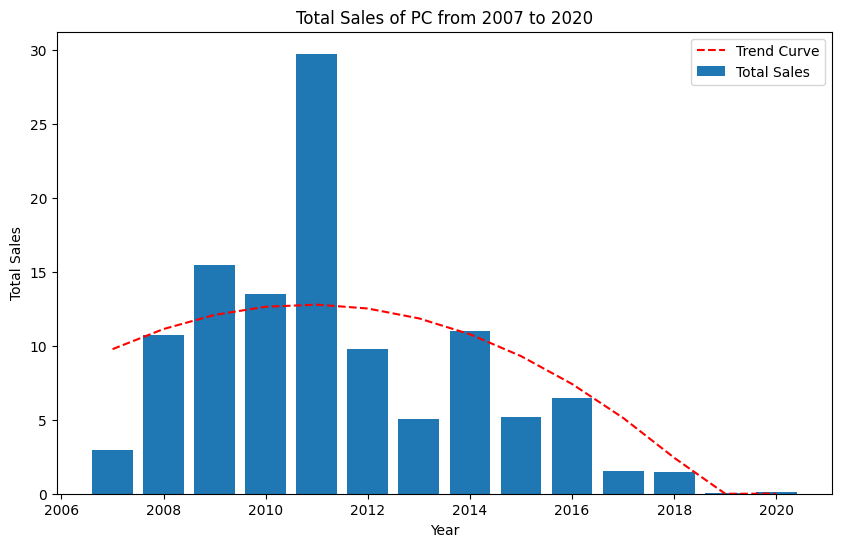

In [58]:
analyzer.single_graph((2007, 2020), 'PC')

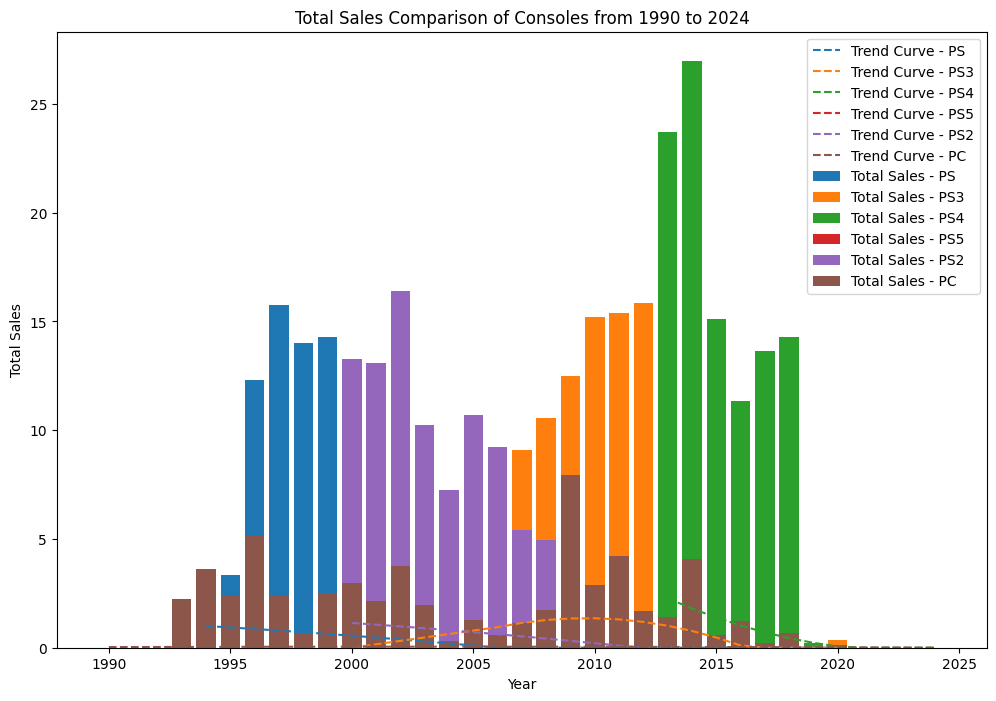

In [61]:
analyzer.stacked_graph((1990, 2024), 'PS', 'PS3', 'PS4', "PS5", 'PS2', 'PC')

In [52]:

# Example usage
analyzer = VideoGameSalesAnalyzer('vgchartz-2024.csv')
analyzer.clean_data()
analyzer.assign_console_mfg()

sales_2022 = analyzer.filter_and_group_by_year(2021)
sales_2022.head()


All items are covered.


,release_date,console,total_sales
0,2021,All,0.0
1,2021,NS,0.0
2,2021,PC,0.0
3,2021,PS4,0.0
4,2021,PS5,0.0


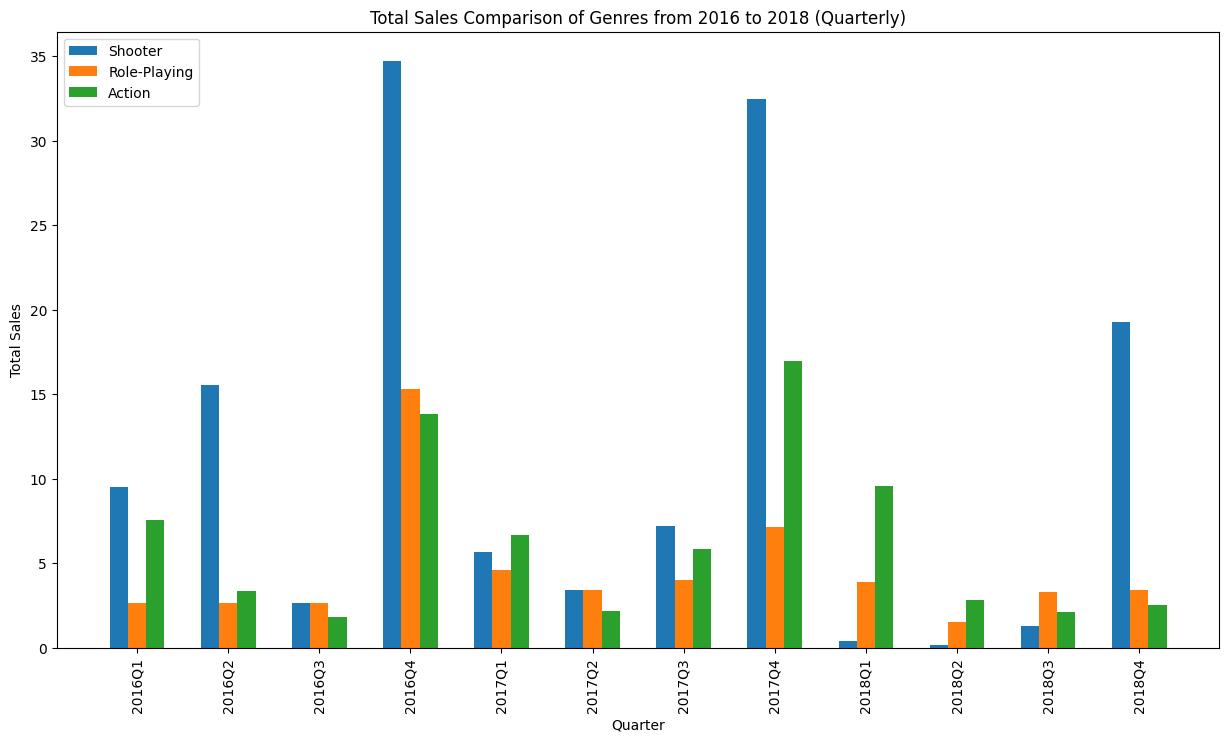

In [53]:
analyzer.graph_genre_quarterly((2016,2018), 'Shooter', 'Role-Playing', 'Action')

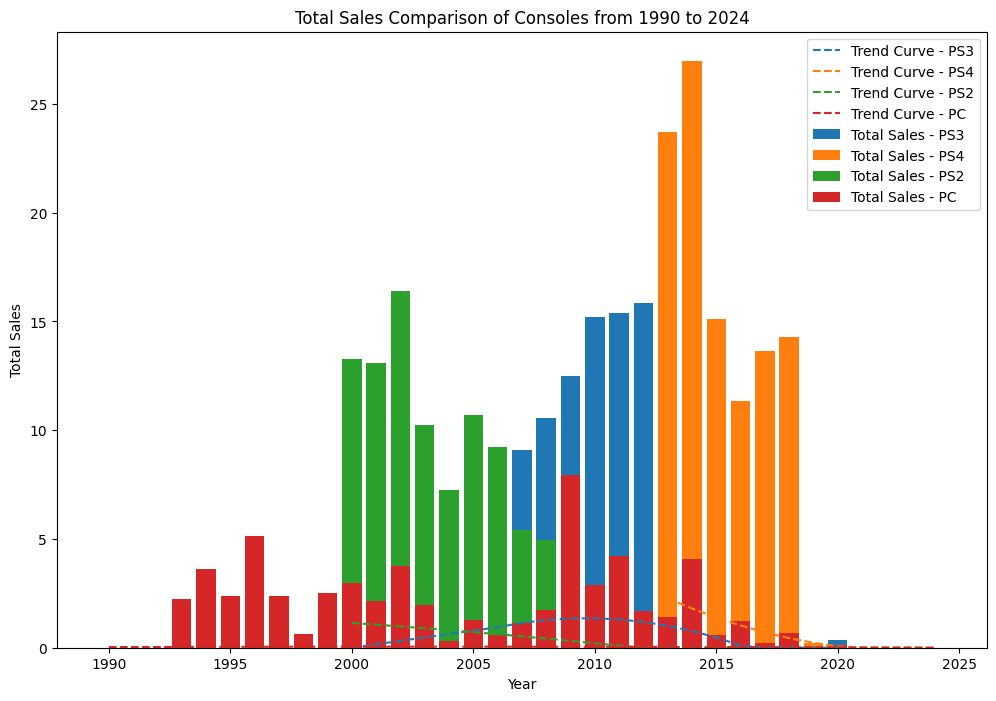

In [54]:
analyzer.stacked_graph((1990, 2024), 'PS3', 'PS4', 'PS2', 'PC')